In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# %matplotlib inline

# STEP 1: Let's ingest (and inspect) the tourism data

**Source:** https://data.europa.eu/euodp/en/data/dataset/dKveFoy4vFts8fta4Q4SIw

**Description:**
An arrival is defined as a person (tourist) who arrives at a tourist accommodation establishment and checks in. The arrivals of same-day visitors spending only a few hours during the day (no overnight stay, the date of arrival and departure are the same) at the establishment are excluded.

#### In the code below, you can change:
`country_code1`

`country_code2` 
#### to any 2 european countries available in the dataset. Explanation for country codes in the link:
https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes

In [2]:
# read tsv file
tourism_df = pd.read_csv('./data/tourism/tour_occ_arm.tsv', sep='\t', na_values=[': '])

# change column format/type to Timestamps (easier manipulation)
new_columns = [col if i ==0 else pd.to_datetime(col, format='%YM%m ') for i,col in enumerate(tourism_df.columns)]
tourism_df.columns = new_columns
# removing some characters from data
tourism_df = tourism_df.replace(to_replace=['b','c','d','e'], value='', regex=True)
tourism_df.head()

,"c_resid,unit,nace_r2,geo\time",2019-03-01 00:00:00,2019-02-01 00:00:00,2019-01-01 00:00:00,2018-12-01 00:00:00,2018-11-01 00:00:00,2018-10-01 00:00:00,2018-09-01 00:00:00,2018-08-01 00:00:00,2018-07-01 00:00:00,...,1990-10-01 00:00:00,1990-09-01 00:00:00,1990-08-01 00:00:00,1990-07-01 00:00:00,1990-06-01 00:00:00,1990-05-01 00:00:00,1990-04-01 00:00:00,1990-03-01 00:00:00,1990-02-01 00:00:00,1990-01-01 00:00:00
0,"FOR,NR,I551,AL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"FOR,NR,I551,AT",2024373.0,2017723,1820787,1893315,1057905,1500249,1972101,2543213,2495439,...,945889.0,1590481.0,1964762.0,1730317.0,1344426.0,975041.0,908961.0,1046792.0,1101877.0,912764.0
2,"FOR,NR,I551,BE",NaN,436278,410211,555252,545507,618393,582555,626422,625304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"FOR,NR,I551,BG",134630.0,124065,149668,116797,95685,151915,460504,783088,767907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"FOR,NR,I551,CH",NaN,NaN,NaN,NaN,561421,792899,1018206,1292138,1280739,...,623146.0,933963.0,1108888.0,1023482.0,868982.0,680018.0,592948.0,571932.0,468756.0,385405.0


In [3]:
# extracting data from a specific country, by country code
country_code1 = 'AT'
country1_tourism_df = tourism_df[tourism_df.iloc[:, 0] == f'TOTAL,NR,I551,{country_code1}']
# Transposing data so Timestamps go in index
country1_tourism_df = country1_tourism_df.T[1:][-1:0:-1].astype(int)
country1_tourism_df.columns = [f'Arrivals,{country_code1}']

# extracting data from a specific country, by country code
country_code2 = 'PT'
country2_tourism_df = tourism_df[tourism_df.iloc[:, 0] == f'TOTAL,NR,I551,{country_code2}']
# Transposing data so Timestamps go in index
country2_tourism_df = country2_tourism_df.T[1:][-1:0:-1].astype(int)
country2_tourism_df.columns = [f'Arrivals,{country_code2}']

In [4]:
country1_tourism_df.head()

,"Arrivals,AT"
1990-01-01 00:00:00,1178994
1990-02-01 00:00:00,1431998
1990-03-01 00:00:00,1404603
1990-04-01 00:00:00,1204998
1990-05-01 00:00:00,1332797


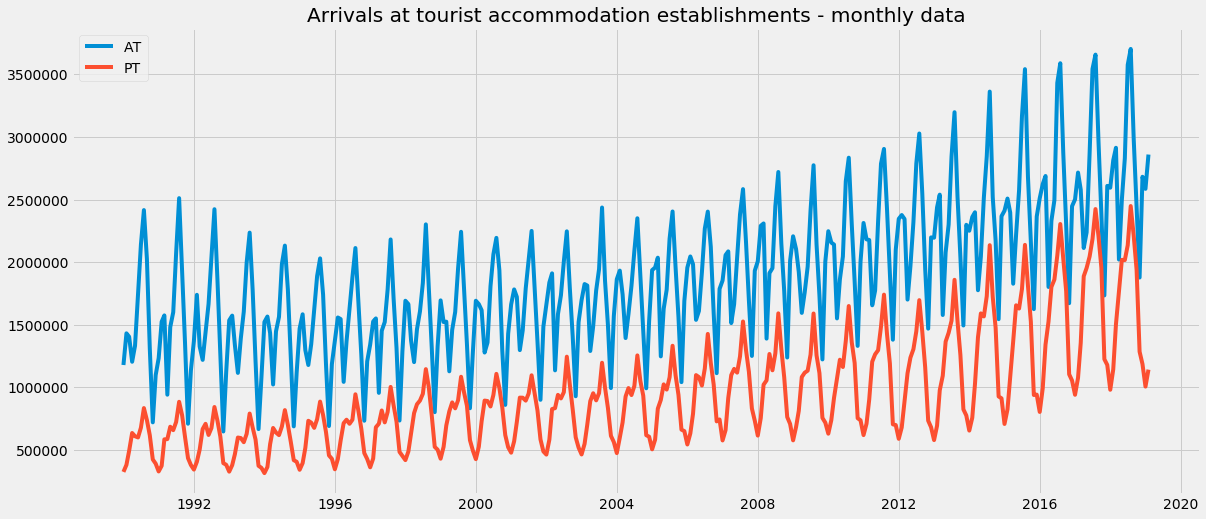

In [5]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18,8))
plt.plot(country1_tourism_df.index, country1_tourism_df.values, label=country_code1)
plt.plot(country2_tourism_df.index, country2_tourism_df.values, label=country_code2)
plt.legend()
plt.title('Arrivals at tourist accommodation establishments - monthly data')
plt.show()

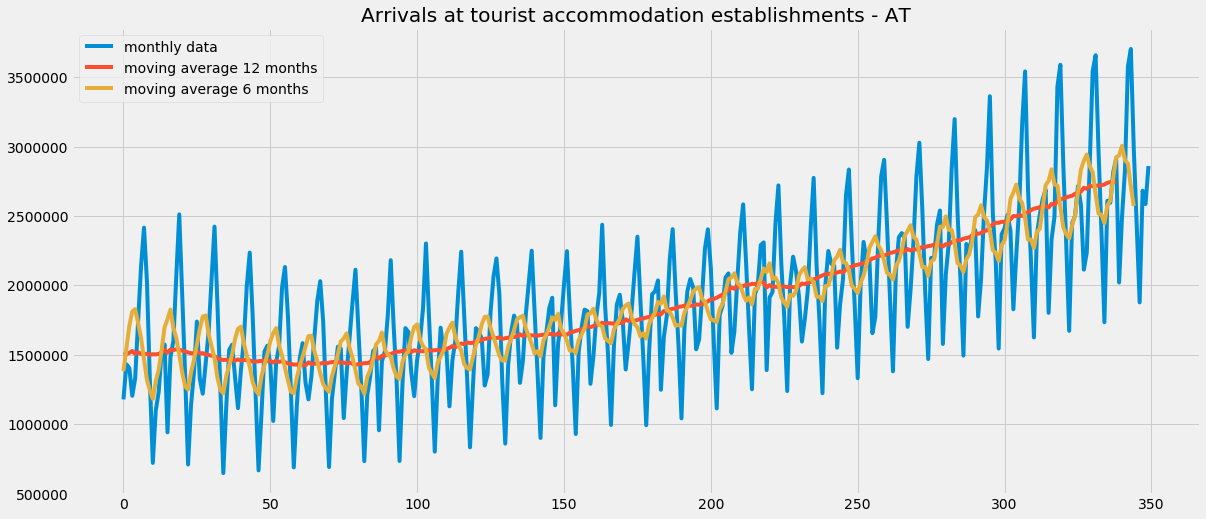

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

country1_ave12 = moving_average(country1_tourism_df.values.reshape(-1), 12)
country1_ave6 = moving_average(country1_tourism_df.values.reshape(-1), 6)

plt.figure(figsize=(18,8))
plt.plot(country1_tourism_df.values, label='monthly data')
plt.plot(country1_ave12, label='moving average 12 months')
plt.plot(country1_ave6, label='moving average 6 months')

plt.legend()
plt.title(f'Arrivals at tourist accommodation establishments - {country_code1}')
plt.show()

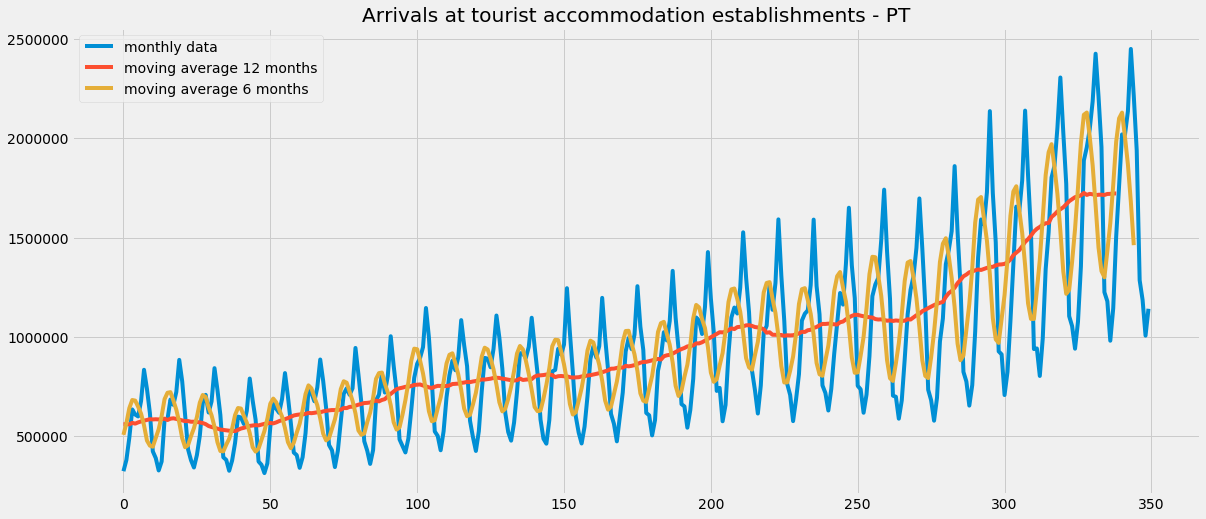

In [7]:
country2_ave12 = moving_average(country2_tourism_df.values.reshape(-1), 12)
country2_ave6 = moving_average(country2_tourism_df.values.reshape(-1), 6)

plt.figure(figsize=(18,8))
plt.plot(country2_tourism_df.values, label='monthly data')
plt.plot(country2_ave12, label='moving average 12 months')
plt.plot(country2_ave6, label='moving average 6 months')

plt.legend()
plt.title(f'Arrivals at tourist accommodation establishments - {country_code2}')
plt.show()

### *Can you get any interesting insight from the data for the countries in your selection?*

# STEP 2: Let's ingest (and inspect) the weather data

- For the training of the models, we will use ERA5 Reanalysis data. 

- We will use previously downloaded monthly data, so we have the same time granularity as the tourism arrivals data

- We will explore t2m and tp variables, but you may have more data than that depending on what you downloaded


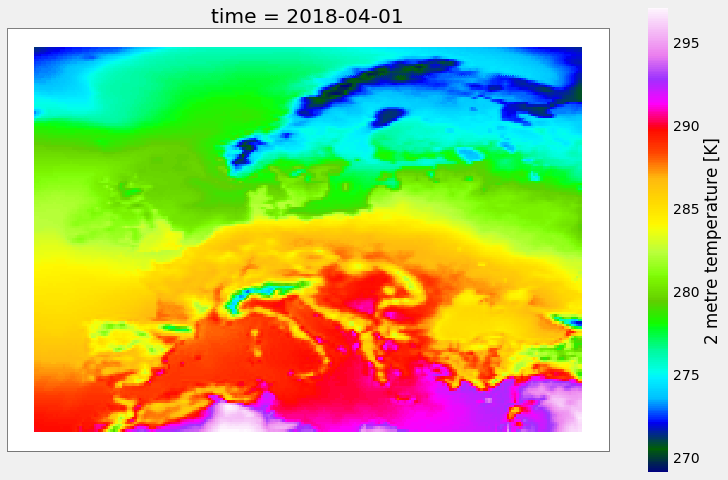

In [8]:
wx_data = xr.open_dataset('./data/weather/era5_EU_monthly.nc')
plt.figure(figsize=(12,8))
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=data_crs)
wx_data.t2m.sel(time='2018-04').plot(ax=ax,transform=data_crs, cmap='gist_ncar')
plt.show()

In [9]:
# define a country_mask array so we can get data for any EU country 
# this might take some time (~30secs)
country_mask = regionmask.defined_regions.natural_earth.countries_50.mask(wx_data, 
                                                                          lon_name='longitude', 
                                                                          lat_name='latitude')

In [10]:
def extract_data_for_country(country_name, country_mask, wx_data):
    country_id = regionmask.defined_regions.natural_earth.countries_50.map_keys(country_name)
    wx_data = wx_data.where(country_mask==country_id)
    wx_data = wx_data.dropna('latitude', how='all')
    wx_data = wx_data.dropna('longitude', how='all')
    return wx_data
    

In [11]:
# this might also take some time, but less (~8secs)
country1_wx = extract_data_for_country('Austria', country_mask, wx_data)
country2_wx = extract_data_for_country('Portugal', country_mask, wx_data)

In [12]:
# Available country codes, for reference
regionmask.defined_regions.natural_earth.countries_50.map_keys

<bound method Regions_cls.map_keys of 241 'Natural Earth Countries: 50m' Regions ()
ZW ZM YE VN VE V VU UZ UY FSM MH MP VI GU AS PR US GS IO SH PN AI FK KY BM VG TC MS JE GG IM GB AE UA UG TM TR TN TT TO TG TL TH TZ TJ TW SYR CH S SW SR SS SD LK E KR ZA SO SL SB SK SLO SG SL SC RS SN SA ST RSM WS VC LC KN RW RUS RO QA P PL PH PE PY PG PA PW PK OM N KP NG NE NI NZ NU CK NL AW CW NP NR NA MZ MA WS ME MN MD MC MX MU MR M ML MV MY MW MG MK L LT FL LY LR LS LB LV LA KG KW KO KI KE KZ J J J I IS PAL IRL IRQ IRN INDO IND IS HU HN HT GY GW GN GT GD GR GH D GE GM GA F PM WF MF BL PF NC TF AI FIN FJ ET EST ER GQ SV EG EC DO DM DJ GL FO DK CZ CN CY CU HR CI CR DRC CG KM CO CN MO HK CL TD CF CV CA CM KH MM BI BF BG BN BR BW BiH BO BT BJ BZ B BY BB BD BH BS AZ A AU IOT HM NF AU ARM AR AG AO AND DZ AL AF SG AQ SX>

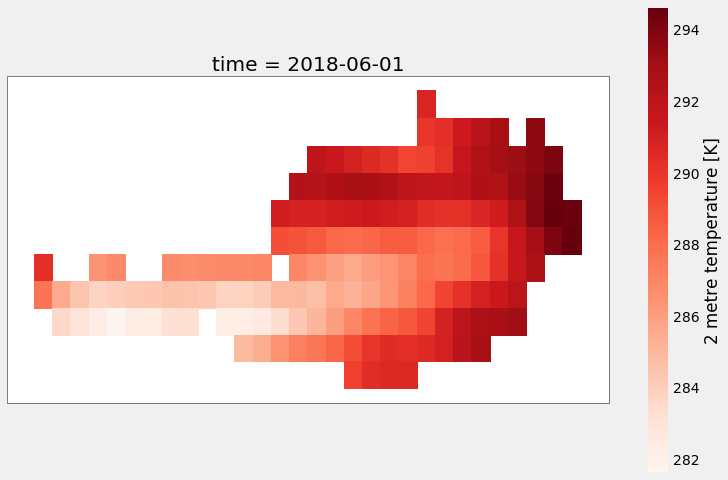

In [13]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Mercator())
p = country1_wx.t2m.sel(time='2018-06').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds')

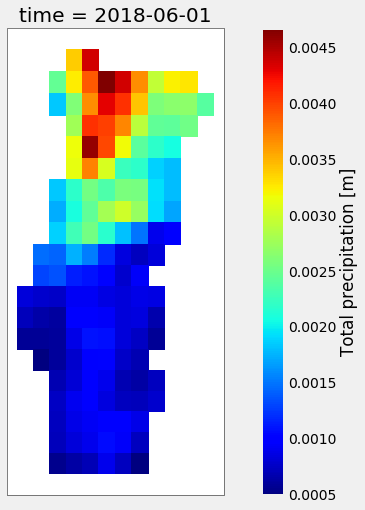

In [14]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Mercator())
p = country2_wx.tp.sel(time='2018-06').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet')

# Can we find interesting correlations between Weather x Arrivals data

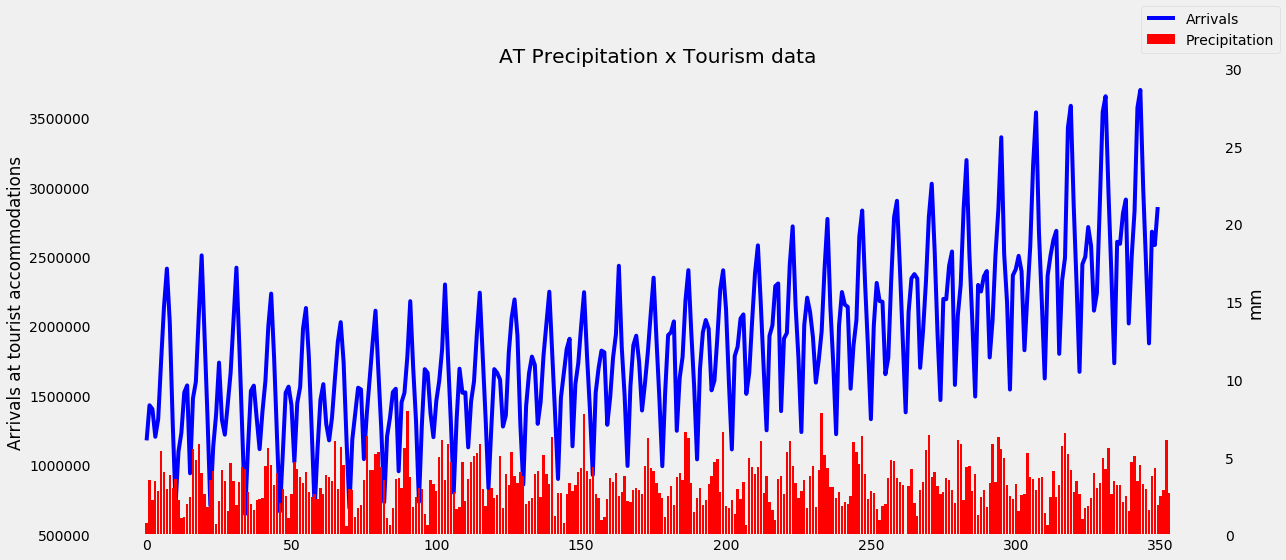

In [15]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax.plot(country1_tourism_df.values, 
        label='Arrivals', 
        color='blue')

ax2.bar(range(country1_wx.dims['time']),
        country1_wx.tp.mean(axis=(1,2))*1000, 
        label='Precipitation', color='red')

ax2.set_ylim(0,30)

ax.set_ylabel('Arrivals at tourist accommodations')
ax2.set_ylabel('mm')

ax.grid(False)
ax2.grid(False)

fig.legend(loc="upper right")
plt.title(f'{country_code1} Precipitation x Tourism data')
plt.show()

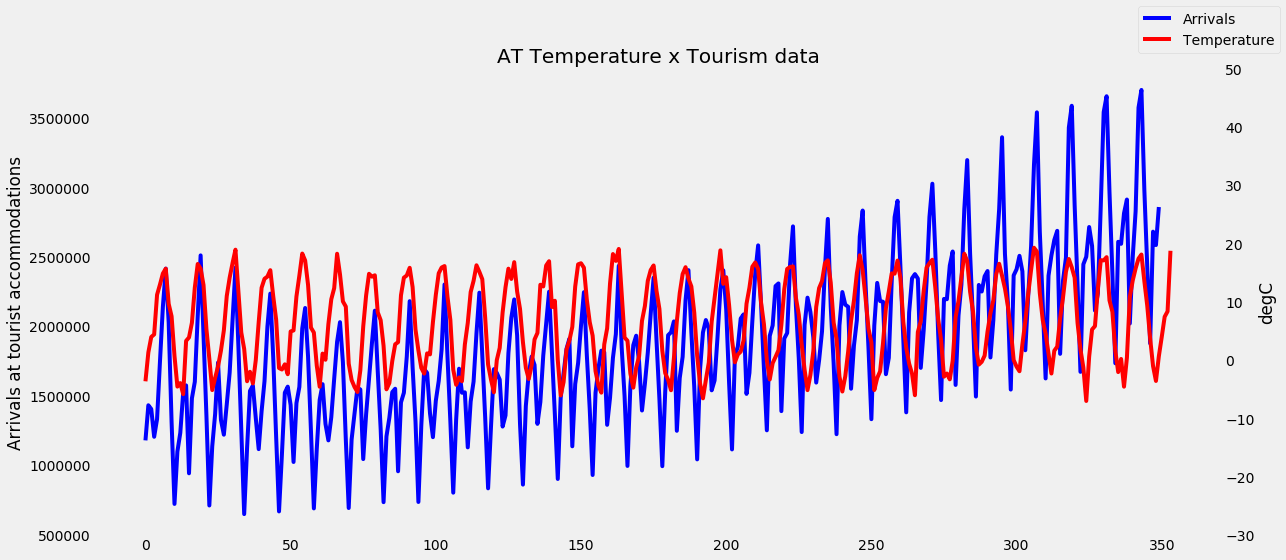

In [16]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax.plot(country1_tourism_df.values, 
        label='Arrivals', 
        color='blue')

ax2.plot(country1_wx.t2m.mean(axis=(1,2))-273.15, 
         label='Temperature', 
         color='red')

ax2.set_ylim(-30,50)
ax.set_ylabel('Arrivals at tourist accommodations')
ax2.set_ylabel('degC')

ax.grid(False)
ax2.grid(False)

fig.legend(loc="upper right")
plt.title(f'{country_code1} Temperature x Tourism data')
plt.show()

# STEP 3: Let's do some modelling

## Important considerations:
    - Training/Test Split
    - Features to be used
    - Algorithm to choose
    - Always check your data

In [17]:
train_period = ('2000-1-1','2015-1-1')
test_period = ('2015-1-1','2019-1-1')

In [18]:
# slicing according to train_period
X_train = country1_wx.t2m.max(axis=(1,2)).sel(time=slice(train_period[0],train_period[1])).values.reshape(-1, 1)
Y_train = country1_tourism_df[pd.Timestamp(train_period[0]):pd.Timestamp(train_period[1])].values.reshape(-1,1).astype(float)

# slicing according to test_period
X_test = country1_wx.t2m.max(axis=(1,2)).sel(time=slice(test_period[0],test_period[1])).values.reshape(-1, 1)
Y_test = country1_tourism_df[pd.Timestamp(test_period[0]):pd.Timestamp(test_period[1])].values.reshape(-1,1).astype(float)

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((181, 1), (49, 1), (181, 1), (49, 1))

### We will try 2 different regression algorithms available from the sklearn package

###### Random Forest Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [21]:
rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train, Y_train.reshape(-1))

Y_pred_rf = rf.predict(X_test)

rf_r2 = metrics.r2_score(Y_test, Y_pred_rf)
rf_mae = metrics.mean_absolute_error(Y_test, Y_pred_rf)
rf_rmse = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_rf))

print(f' Random Forest Regression R2   = {rf_r2:17.6f}')
print(f' Random Forest Regression MAE  = {rf_mae:17.6f}')
print(f' Random Forest Regression RMSE = {rf_rmse:17.6f}')

 Random Forest Regression R2   =         -0.938641
 Random Forest Regression MAE  =     622935.606531
 Random Forest Regression RMSE =     731004.726051


###### Gradient Boosting Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [23]:
gb = GradientBoostingRegressor()

gb.fit(X_train, Y_train.reshape(-1))

Y_pred_gb = gb.predict(X_test)

gb_r2 = metrics.r2_score(Y_test, Y_pred_gb)
gb_mae = metrics.mean_absolute_error(Y_test, Y_pred_gb)
gb_rmse = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_gb))

print(f' Gradient Boosting Regression R2   = {gb_r2:17.6f}')
print(f' Gradient Boosting Regression MAE  = {gb_mae:17.6f}')
print(f' Gradient Boosting Regression RMSE = {gb_rmse:17.6f}')

 Gradient Boosting Regression R2   =         -0.916175
 Gradient Boosting Regression MAE  =     627220.652350
 Gradient Boosting Regression RMSE =     726756.735625


### Let's visualize these predictions

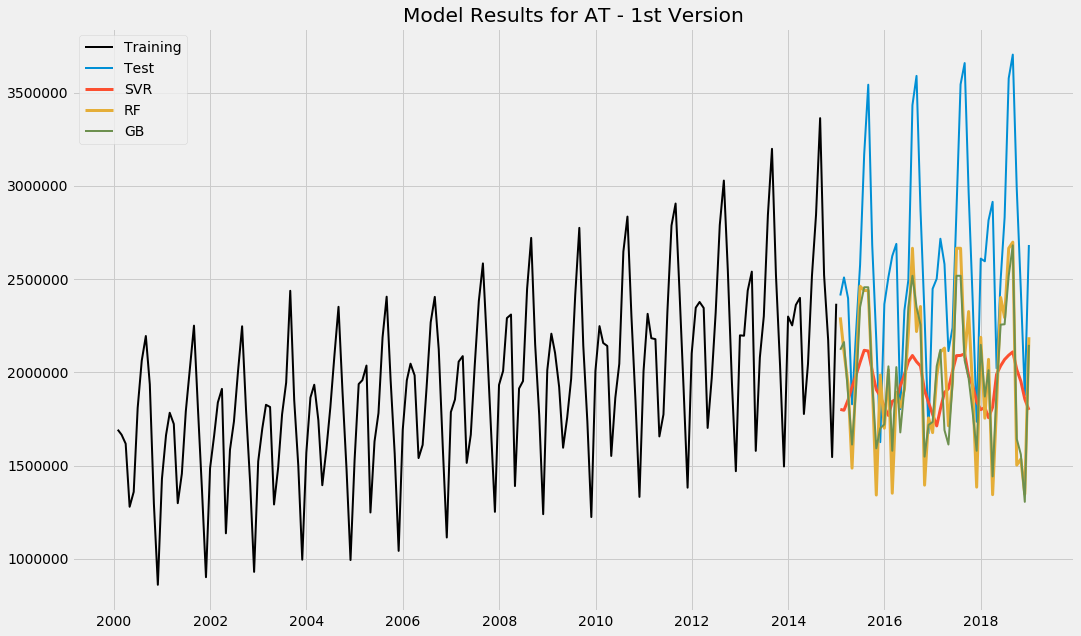

In [24]:
plt.figure(figsize=(16,10))
train_index = pd.date_range(train_period[0],train_period[1], freq='1M')
test_index = pd.date_range(test_period[0],test_period[1], freq='1M')
plt.plot(train_index,Y_train[:-1], label='Training', color='black', lw=2)
plt.plot(test_index,Y_test[:-1], label='Test', lw=2)
plt.plot(test_index,Y_pred_svr[:-1], label= 'SVR', lw=3)
plt.plot(test_index,Y_pred_rf[:-1], label= 'RF', lw=3)
plt.plot(test_index,Y_pred_gb[:-1], label= 'GB', lw=2)
plt.legend()
plt.title(f'Model Results for {country_code1} - 1st Version')
plt.show()

# Why so bad?

- Our predictors only explain the data variability in a short timescale (essentially: winter v summer)
- We need another feature that is capable of adding information about longer timescales to the model, so the model can learn 
- This can surprise you


In [25]:
# adding month number as a feature
month_train_array = np.arange(0, 
                              len(pd.date_range(train_period[0],train_period[1], freq='1M'))+1)
month_test_array = np.arange(month_train_array[-1]+1, 
                             month_train_array[-1]+len(pd.date_range(test_period[0],test_period[1], freq='1M'))+2)

month_train_array, month_test_array

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [26]:
X_train_2 = np.column_stack([X_train[:,0], month_train_array])
X_test_2 = np.column_stack([X_test[:,0], month_test_array])

X_train_2.shape, X_test_2.shape, Y_train.shape, Y_test.shape

((181, 2), (49, 2), (181, 1), (49, 1))

In [28]:
rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train_2, Y_train.reshape(-1))

Y_pred_rf = rf.predict(X_test_2)

rf_r2 = metrics.r2_score(Y_test, Y_pred_rf)
rf_mae = metrics.mean_absolute_error(Y_test, Y_pred_rf)
rf_rmse = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_rf))

print(f' Random Forest Regression R2   = {rf_r2:17.6f}')
print(f' Random Forest Regression MAE  = {rf_mae:17.6f}')
print(f' Random Forest Regression RMSE = {rf_rmse:17.6f}')

 Random Forest Regression R2   =          0.435417
 Random Forest Regression MAE  =     333202.257143
 Random Forest Regression RMSE =     394489.403006


In [29]:
gb = GradientBoostingRegressor()

gb.fit(X_train_2, Y_train.reshape(-1))
Y_pred_gb = gb.predict(X_test_2)

gb_r2 = metrics.r2_score(Y_test, Y_pred_gb)
gb_mae = metrics.mean_absolute_error(Y_test, Y_pred_gb)
gb_rmse = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_gb))

print(f' Gradient Boosting Regression R2   = {gb_r2:17.6f}')
print(f' Gradient Boosting Regression MAE  = {gb_mae:17.6f}')
print(f' Gradient Boosting Regression RMSE = {gb_rmse:17.6f}')

 Gradient Boosting Regression R2   =          0.452262
 Gradient Boosting Regression MAE  =     327808.441549
 Gradient Boosting Regression RMSE =     388559.951845


## These are much better results, let's visualize them

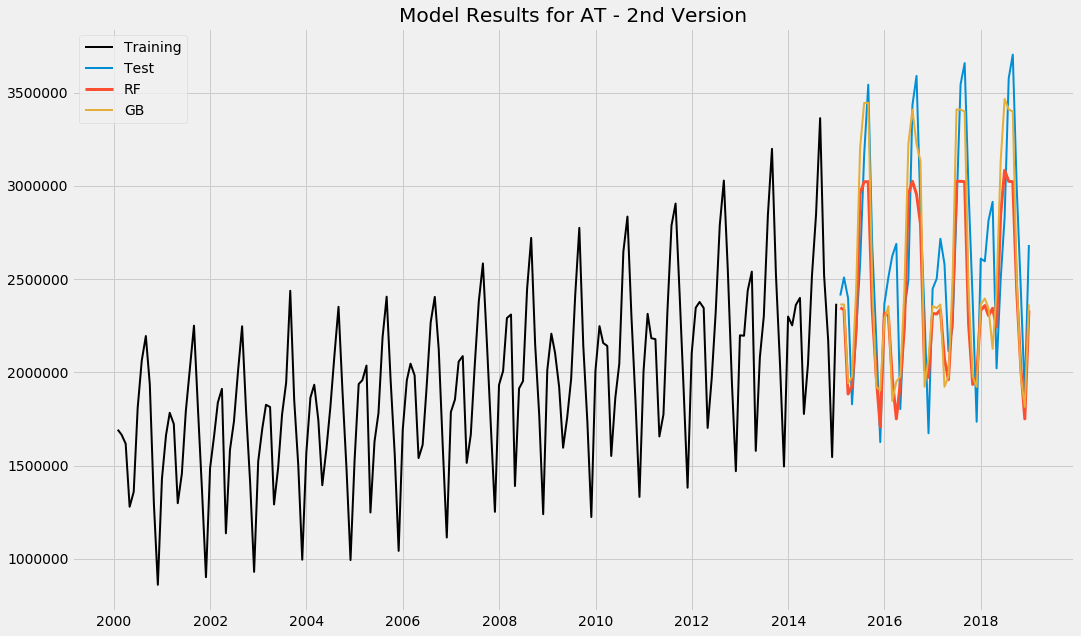

In [30]:
plt.figure(figsize=(16,10))
train_index = pd.date_range(train_period[0],train_period[1], freq='1M')
test_index = pd.date_range(test_period[0],test_period[1], freq='1M')
plt.plot(train_index,Y_train[:-1], label='Training', color='black', lw=2)
plt.plot(test_index,Y_test[:-1], label='Test', lw=2)
# plt.plot(test_index,Y_pred_svr[:-1], label='SVR', lw=3)
plt.plot(test_index,Y_pred_rf[:-1], label= 'RF', lw=3)
plt.plot(test_index,Y_pred_gb[:-1], label= 'GB', lw=2)
plt.title(f'Model Results for {country_code1} - 2nd Version')
plt.legend()
plt.show()